In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Завантаження датасету MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

In [16]:
# Визначення генератора
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.fc = nn.Linear(input_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, output_size)

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [17]:
# Визначення дискримінатора
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [18]:
# Визначення розмірів вхідного шумового вектора та розміру зображення
input_size = 100
output_size = 28 * 28

# Ініціалізація генератора та дискримінатора
generator = Generator(input_size, output_size)
discriminator = Discriminator(output_size)

# Визначення функції втрат та оптимізаторів
criterion = nn.BCELoss()
lr = 0.0002
generator_optimizer = optim.Adam(generator.parameters(), lr=lr)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr)

In [21]:
# Навчання моделі GAN
num_epochs = 50
for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(data_loader):
        batch_size = real_images.size(0)
        
        # Навчання дискримінатора
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        
        # Очистити градієнти
        discriminator_optimizer.zero_grad()
        
        # Пропуск реальних зображень через дискримінатор
        real_images = real_images.view(-1, output_size)
        real_outputs = discriminator(real_images)
        d_loss_real = criterion(real_outputs, real_labels)
        d_real_score = real_outputs
        
        # Генерація шуму та пропуск його через генератор
        random_noise = torch.randn(batch_size, input_size)
        fake_images = generator(random_noise)
        
        # Пропуск згенерованих зображень через дискримінатор
        fake_outputs = discriminator(fake_images)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_fake_score = fake_outputs
        
        # Загальна втрата дискримінатора та зворотне поширення помилки
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        discriminator_optimizer.step()
        
        # Навчання генератора
        generator_optimizer.zero_grad()
        
        # Генерація нових зображень та пропуск їх через дискримінатор
        random_noise = torch.randn(batch_size, input_size)
        fake_images = generator(random_noise)
        outputs = discriminator(fake_images)
        
        # Втрата генератора та зворотне поширення помилки
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        generator_optimizer.step()
        
        if (batch_idx+1) % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(data_loader)}], "
                  f"D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}, "
                  f"D(x): {d_real_score.mean().item():.4f}, D(G(z)): {d_fake_score.mean().item():.4f}")

# Збереження моделі
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

Epoch [1/50], Batch [200/938], D_loss: 0.0645, G_loss: 3.6884, D(x): 0.9657, D(G(z)): 0.0284
Epoch [1/50], Batch [400/938], D_loss: 0.0331, G_loss: 4.4620, D(x): 0.9815, D(G(z)): 0.0140
Epoch [1/50], Batch [600/938], D_loss: 0.0226, G_loss: 4.9549, D(x): 0.9905, D(G(z)): 0.0128
Epoch [1/50], Batch [800/938], D_loss: 0.0144, G_loss: 5.5406, D(x): 0.9913, D(G(z)): 0.0055
Epoch [2/50], Batch [200/938], D_loss: 0.0103, G_loss: 6.1800, D(x): 0.9961, D(G(z)): 0.0063
Epoch [2/50], Batch [400/938], D_loss: 0.0073, G_loss: 6.2946, D(x): 0.9959, D(G(z)): 0.0031
Epoch [2/50], Batch [600/938], D_loss: 0.0066, G_loss: 6.6260, D(x): 0.9971, D(G(z)): 0.0037
Epoch [2/50], Batch [800/938], D_loss: 0.0052, G_loss: 6.9895, D(x): 0.9975, D(G(z)): 0.0027
Epoch [3/50], Batch [200/938], D_loss: 0.0040, G_loss: 7.1618, D(x): 0.9985, D(G(z)): 0.0024
Epoch [3/50], Batch [400/938], D_loss: 0.0029, G_loss: 7.3654, D(x): 0.9986, D(G(z)): 0.0015
Epoch [3/50], Batch [600/938], D_loss: 0.0024, G_loss: 7.4676, D(x): 0

Epoch [22/50], Batch [800/938], D_loss: 0.0000, G_loss: 22.1917, D(x): 1.0000, D(G(z)): 0.0000
Epoch [23/50], Batch [200/938], D_loss: 0.0000, G_loss: 20.8133, D(x): 1.0000, D(G(z)): 0.0000
Epoch [23/50], Batch [400/938], D_loss: 0.0000, G_loss: 21.7680, D(x): 1.0000, D(G(z)): 0.0000
Epoch [23/50], Batch [600/938], D_loss: 0.0000, G_loss: 22.7154, D(x): 1.0000, D(G(z)): 0.0000
Epoch [23/50], Batch [800/938], D_loss: 0.0000, G_loss: 22.8998, D(x): 1.0000, D(G(z)): 0.0000
Epoch [24/50], Batch [200/938], D_loss: 0.0000, G_loss: 23.1256, D(x): 1.0000, D(G(z)): 0.0000
Epoch [24/50], Batch [400/938], D_loss: 0.0000, G_loss: 22.7558, D(x): 1.0000, D(G(z)): 0.0000
Epoch [24/50], Batch [600/938], D_loss: 0.0000, G_loss: 22.1937, D(x): 1.0000, D(G(z)): 0.0000
Epoch [24/50], Batch [800/938], D_loss: 0.0000, G_loss: 22.6387, D(x): 1.0000, D(G(z)): 0.0000
Epoch [25/50], Batch [200/938], D_loss: 0.0000, G_loss: 23.7027, D(x): 1.0000, D(G(z)): 0.0000
Epoch [25/50], Batch [400/938], D_loss: 0.0000, G_

Epoch [44/50], Batch [600/938], D_loss: 0.0000, G_loss: 35.0324, D(x): 1.0000, D(G(z)): 0.0000
Epoch [44/50], Batch [800/938], D_loss: 0.0000, G_loss: 37.2557, D(x): 1.0000, D(G(z)): 0.0000
Epoch [45/50], Batch [200/938], D_loss: 0.0000, G_loss: 34.2498, D(x): 1.0000, D(G(z)): 0.0000
Epoch [45/50], Batch [400/938], D_loss: 0.0000, G_loss: 34.5850, D(x): 1.0000, D(G(z)): 0.0000
Epoch [45/50], Batch [600/938], D_loss: 0.0000, G_loss: 35.0355, D(x): 1.0000, D(G(z)): 0.0000
Epoch [45/50], Batch [800/938], D_loss: 0.0000, G_loss: 35.5638, D(x): 1.0000, D(G(z)): 0.0000
Epoch [46/50], Batch [200/938], D_loss: 0.0000, G_loss: 35.4166, D(x): 1.0000, D(G(z)): 0.0000
Epoch [46/50], Batch [400/938], D_loss: 0.0000, G_loss: 35.4982, D(x): 1.0000, D(G(z)): 0.0000
Epoch [46/50], Batch [600/938], D_loss: 0.0000, G_loss: 35.4363, D(x): 1.0000, D(G(z)): 0.0000
Epoch [46/50], Batch [800/938], D_loss: 0.0000, G_loss: 35.8540, D(x): 1.0000, D(G(z)): 0.0000
Epoch [47/50], Batch [200/938], D_loss: 0.0000, G_

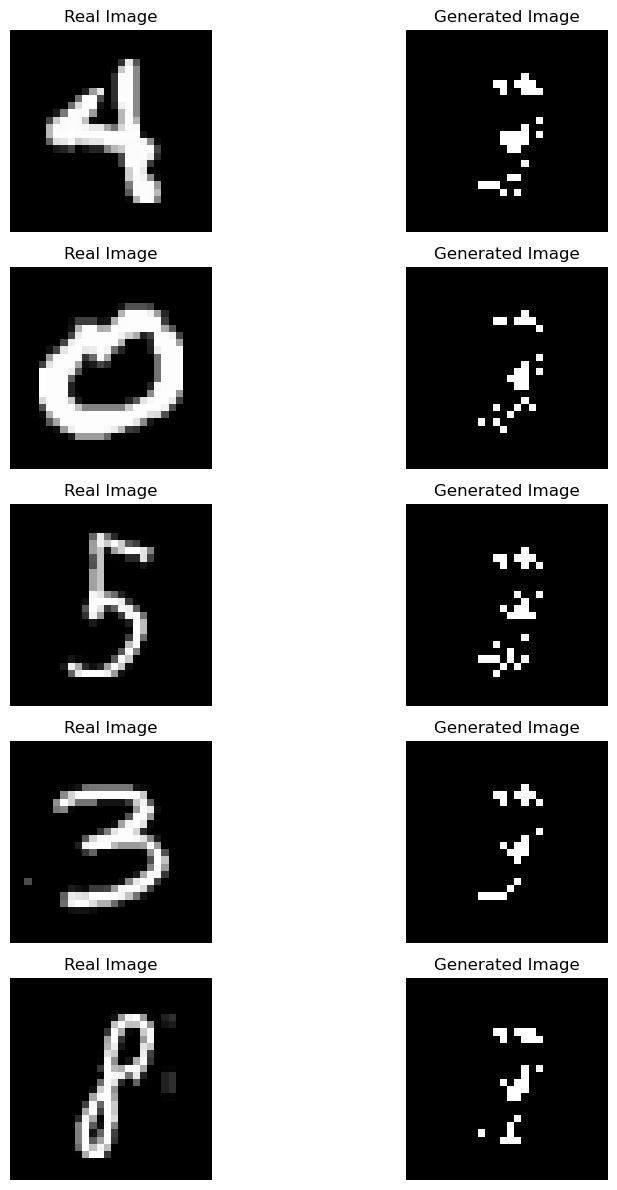

In [22]:
# Завантаження навчених моделей
generator = Generator(input_size, output_size)
generator.load_state_dict(torch.load('generator.pth'))
generator.eval()

# Вибір кількох оригінальних зображень для порівняння
num_images = 5
real_images, _ = next(iter(data_loader))
real_images = real_images[:num_images]

# Генерація зображень за допомогою генератора
random_noise = torch.randn(num_images, input_size)
generated_images = generator(random_noise)

# Бінаризація згенерованих зображень
generated_images = torch.round((generated_images + 1) / 2)  # Від 0 до 1 -> Від 0 до 1 -> Від 0 до 1 -> Від 0 до 1 -> 0 або 1

# Відображення оригінальних та згенерованих зображень
fig, axes = plt.subplots(num_images, 2, figsize=(10, 12))

for i in range(num_images):
    # Оригінальні зображення
    axes[i, 0].imshow(real_images[i].squeeze(), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Real Image')

    # Згенеровані зображення
    axes[i, 1].imshow(generated_images[i].detach().numpy().reshape(28, 28), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Generated Image')

plt.tight_layout()
plt.show()